In [1]:
#All Imports go here
import numpy as np
import pandas as pd
from PIL import Image
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import scipy
from glob import glob
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy
from tflearn.data_utils import shuffle, to_categorical
import matplotlib.image as image

In [2]:
'''
Here we do the same image preprocessing as in the training phase:
First We read the image and run the Histogram Equalization method on it
After that we resize the image and prepare the normalization
'''
img_size = 64

def transform_images(img, width, height):
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    img = cv2.resize(img, (width, height), interpolation = cv2.INTER_CUBIC)
    return img

def get_one_img(data_folder):
    image_filenames = os.listdir(data_folder)
    image_sample = random.sample(image_filenames, 1)
    image_path = os.path.join(data_folder, image_sample[0])
    img = cv2.imread(image_path)
    return img

img_prepocessing = ImagePreprocessing()
img_prepocessing.add_featurewise_zero_center()
img_prepocessing.add_featurewise_stdnorm()

In [3]:
'''
Here is exactly the same CNN described in the training phase
'''


network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prepocessing)
conv_1 = conv_2d(network, 32, 3, activation='relu', name='conv_1')
network = max_pool_2d(conv_1, 2)
conv_2 = conv_2d(network, 64, 3, activation='relu', name='conv_2')
conv_3 = conv_2d(conv_2, 64, 3, activation='relu', name='conv_3')
network = max_pool_2d(conv_3, 2)
network = fully_connected(network, 512, activation='relu')
network = dropout(network, 0.5)
network = fully_connected(network, 2, activation='softmax')
acc = Accuracy(name="Accuracy")
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)
model = tflearn.DNN(network, checkpoint_path='model_cat_dog_10.tflearn', max_checkpoints = 3,
                    tensorboard_verbose = 3, tensorboard_dir='tmp/tflearn_logs/')
model.load("model_cat_dog_10.tflearn-450")
    

In [254]:
'''
Now we read a image that the CNN never seen before and prepare it for the prediction step
'''

img = get_one_img("images_for_test/")
img = transform_images(img, img_size, img_size)
img2 = scipy.misc.imresize(img, (64, 64), interp="bicubic").astype(np.float32, casting='unsafe')

In [255]:
#We made the prediction
prediction = model.predict([img2])



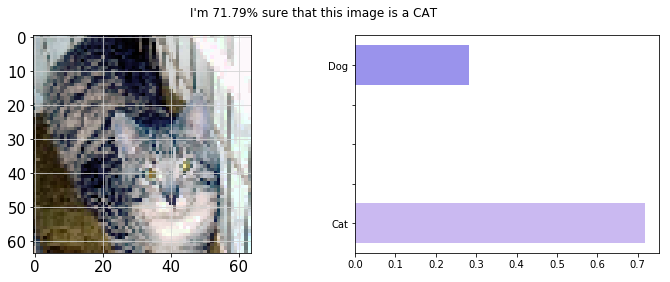

In [256]:
#With the prediction done we just plot the results for better visualization

N = 1
dog = (prediction[0][0])
cat = (prediction[0][1])
ind = np.arange(N)  # the y locations for the groups
width = 0.1      # the width of the bars

fig, axs = plt.subplots(1,2)
fig.set_size_inches(12, 4)

axs[0].imshow(img)
axs[0].yaxis.tick_left()
axs[0].tick_params(axis='y', colors='black', labelsize=15)
axs[0].tick_params(axis='x', colors='black', labelsize=15)
axs[0].grid(b=True, which='major', color='#D3D3D3', linestyle='-')

rects1 = axs[1].barh(0.5, dog, width, color='#9A93EC')
rects2 = axs[1].barh(ind + width, cat, width, color='#CAB9F1')
# add some text for labels, title and axes ticks
axs[1].set_yticklabels(('', 'Cat', '', '', '','Dog'))
if prediction[0][0] > prediction[0][1]:
    fig.suptitle("I'm {:.2f}% sure that this image is a DOG ".format(prediction[0][0]*100))
else:
    fig.suptitle("I'm {:.2f}% sure that this image is a CAT".format(prediction[0][1]*100))


    
plt.show()